# Food Recognition System For Passio
## By: Sarah Hernandez



In [149]:
import tensorflow as tf
import numpy as np
import pickle
import os
import cv2
import math
from random import shuffle
import matplotlib.pyplot as plt
import skimage
    


### Goal 1: Prepare a Dataset:

#### Step 1: Explore Dataset


In [6]:
currentDir = os.getcwd()
foodDir = currentDir + "/Food"
notFoodDir = currentDir + "/Not Food"

foodList = os.listdir(foodDir)
numFoods = 144 #len(foodList), entered original length before data augmentation

notFoodList = os.listdir(notFoodDir)
numNotFoods = 125 #len(notFoodList), entered original length before data augmentation

print("Foods: " + str(numFoods))
print("Not Foods: " + str(numNotFoods))

for i in range(3):
    testDir = foodDir + "/" + foodList[i]
    img = cv2.imread(testDir)
    print("Example Food Shape: " + str(img.shape))
    testDir2 = notFoodDir + "/" + notFoodList[i]
    img2 = cv2.imread(testDir2)
    print("Example Not Food Shape: " + str(img2.shape))
    


Foods: 144
Not Foods: 125
Example Food Shape: (640, 640, 3)
Example Not Food Shape: (4032, 3024, 3)
Example Food Shape: (480, 640, 3)
Example Not Food Shape: (3024, 4032, 3)
Example Food Shape: (612, 612, 3)
Example Not Food Shape: (640, 360, 3)


So we have fewer than 300 images of food and not food, of various square and rectangular sizes. This is a rather small data set, so we'll augment the data using a few tricks:


#### Step 2: Augment Data

In [8]:
# Get array of directories of food and not food
def get_image_dirs(foodList, notFoodList):
    
    foodDirs = []
    for food in foodList:
        if not food.startswith('.'):
            foodDirs.append(foodDir + "/" + food)
    
    notFoodDirs = []
    for notFood in notFoodList:
        if not notFood.startswith('.'):
            notFoodDirs.append(notFoodDir + "/" + notFood)
        
    
    return foodDirs, notFoodDirs
        

foodDirs, notFoodDirs = get_image_dirs(foodList, notFoodList)



In [332]:

# First trick: flip and rotate images
for i in range(numFoods):
    img = cv2.imread(foodDirs[i])
    img2 = np.fliplr(img)
    img3 = np.flipud(img)
    img4 = np.rot90(img)
    cv2.imwrite(foodDir + "/lr" + str(i) + ".jpg", img2)
    cv2.imwrite(foodDir + "/ud" + str(i) + ".jpg", img3)
    cv2.imwrite(foodDir + "/rot90" + str(i) + ".jpg", img4)
    
for i in range(numNotFoods):
    img = cv2.imread(notFoodDirs[i])
    img2 = np.fliplr(img)
    img3 = np.flipud(img)
    img4 = np.rot90(img)
    cv2.imwrite(notFoodDir + "/lr" + str(i) + ".jpg", img2)
    cv2.imwrite(notFoodDir + "/ud" + str(i) + ".jpg", img3)
    cv2.imwrite(notFoodDir + "/rot90" + str(i) + ".jpg", img4)
    
print("Completed")


Completed


In [321]:
# Update Food and NotFood Dirs:
foodList = os.listdir(foodDir)

notFoodList = os.listdir(notFoodDir)

foodDirs, notFoodDirs = get_image_dirs(foodList, notFoodList)

print("Directories created")
    


Directories created


In [441]:
# Second trick: add noise to images:
for i in range(len(foodDirs)):
    
    img = cv2.imread(foodDirs[i])
    img = cv2.resize(img,(256,256))
    row,col,ch= img.shape
    mean = 0
    gauss = np.random.normal(mean,30,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = img + gauss
    cv2.imwrite(foodDir + "/noisy" + str(i) + ".jpg", noisy)


print("Noisy Food Created")

for i in range(len(notFoodDirs)):
    
    img = cv2.imread(notFoodDirs[i])
    img = cv2.resize(img,(256,256))
    row,col,ch= img.shape
    mean = math.ceil(255/2)
    gauss = np.random.normal(mean,50,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = img + gauss
    cv2.imwrite(notFoodDir + "/noisy" + str(i) + ".jpg", noisy)
       
print("Noisy Not Food Created")


Noisy Food Created
Noisy Not Food Created


In [9]:
foodList = os.listdir(foodDir)

notFoodList = os.listdir(notFoodDir)

foodDirs, notFoodDirs = get_image_dirs(foodList, notFoodList)

print("Number of Foods: " + str(len(foodDirs)))
print("Number of Not Foods: " + str(len(notFoodDirs)))


Number of Foods: 1152
Number of Not Foods: 1000


Now we've got something to work with! Next, let's generate the dataset:

#### Step 3: Generate Dataset

In [10]:
import cv2
class Generate_Dataset:
    
    def __init__(self, data_dirs):
        self.data_dirs = data_dirs
        self.labels = []
        self.data_paths = []
        self.images = []
        
        # Now we put all data paths in a single matrix and shuffle it: 
        self.data_paths = np.concatenate([self.data_dirs[0], self.data_dirs[1]])
        shuffle(self.data_paths)
        
        #Next, generate labels:
        for path in self.data_paths:
            self.labels.append(self.generate_data_labels(path))
            self.images.append(self.get_image(path))
        
        
    # Returns label of specified file
    def generate_data_labels(self, directory):
        labels = []
        # Because we're doing a simple binary classification, we can one-hot-encode here:
        if "Not" in directory:
            label = [1, 0]
        else:
            label = [0, 1]
        
        return label
    
    
    def get_data_paths(self, startIndex, endIndex):
        return self.data_paths[startIndex:endIndex]
    
    def get_data_labels(self, startIndex, endIndex):
        return self.labels[startIndex: endIndex]
        
        
    def get_image(self, path):
        img = cv2.imread(path)
        img = cv2.resize(img,(256,256))
        return img
    
    def get_data(self):
        return self.images, self.labels
    
    def get_all_dirs(self):
        return self.data_paths
        
        
        
        
dirs = [foodDirs, notFoodDirs]
dataset = Generate_Dataset(dirs)
images, labels = dataset.get_data()
paths = dataset.get_all_dirs()

print("Dataset Generated")



Dataset Generated


Okay, we've got an array of images, all scaled down to 256x256, and an array of labels that correspond to the images. But we still need to do some preprocessing:

### Step 4: Preprocess Data

In [11]:
def normalize(x):
    #Returns a normalized image, x: input image data in numpy array [256, 256, 3]
    
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [12]:
def preprocess_helper(some_images, some_labels, some_paths, filename, isTraining = False):
    some_images = normalize(some_images)
    #some_images = some_images.reshape((len(some_images), 3, 256, 256))
    
    num_images = len(some_images)
    
    if not isTraining:
        pickle.dump((some_images, some_labels, some_paths), open(filename, "wb"))
    else:
        # break training images into five batches
        for i in range(5):
            newFileName = filename + str(i) + ".p"
            first_index = int(num_images*i/5)
            second_index = int(num_images*(i+1)/5)
            pickle.dump((some_images[first_index:second_index], some_labels[first_index:second_index], some_paths[first_index:second_index]), open(newFileName, "wb"))
        
        
    

def preprocess(currentDir):
    
    validation_images = []
    validation_labels = []
    validation_paths = []
    test_images = []
    test_labels = []
    test_paths = []
    training_images = []
    training_labels = []
    training_paths = []
    # Save 10% of data for validation, and another 10% for testing:
    first_index = int(len(images)*0.1)
    second_index = int(len(images)*0.2)
    
    
    # Save validation set:
    validation_images.extend(images[0:first_index])
    validation_labels.extend(labels[0:first_index])
    validation_paths.extend(paths[0:first_index])
    filename = currentDir + "/" + "preprocess_validation.p"
    preprocess_helper(np.array(validation_images), np.array(validation_labels), np.array(validation_paths), filename)
    print("Validation Set Saved")
    
    # Save testing set:
    test_images.extend(images[first_index:second_index])
    test_labels.extend(labels[first_index:second_index])
    test_paths.extend(paths[first_index:second_index])
    filename = currentDir + "/" + "preprocess_testing.p"
    preprocess_helper(np.array(test_images), np.array(test_labels), np.array(test_paths), filename)
    print("Testing Set Saved")
    
    # Save training set!
    training_images.extend(images[second_index:])
    training_labels.extend(labels[second_index:])
    training_paths.extend(paths[second_index:])
    filename = currentDir + "/" + "preprocess_training"
    preprocess_helper(np.array(training_images), np.array(training_labels), np.array(training_paths), filename, True)
    print("Training Set Saved")
    
    


In [13]:
preprocess(currentDir)
test_images, test_labels, test_paths = pickle.load(open(currentDir + "/" + "preprocess_testing.p", mode = "rb"))
valid_images, valid_labels, valid_paths = pickle.load(open(currentDir + "/" + "preprocess_validation.p", mode = "rb"))

# Split training images and labels into five batches:
train_images = []
train_labels = []
train_paths = []
for i in range(5): 
    batch_images, batch_labels, batch_paths = pickle.load(open(currentDir + "/" + "preprocess_training" + str(i) + ".p", mode = "rb"))
    train_images.append(batch_images)
    train_labels.append(batch_labels)
    train_paths.append(batch_paths)
    
print("All sets created and loaded")

Validation Set Saved
Testing Set Saved
Training Set Saved
All sets created and loaded


### Goal 2: Implement a neural network for classifying food vs non-food

#### Step 1: Prepare Model 
We will prepare the model by creating several helper functions. The first of these will help us get mini-batches as needed for training. The remaining are methods that will ech define a layer of the model: a convolutional layer, a flattening layer, a fully connected layer, or the final output layer. 



In [14]:


# Create methods to get mini-batches
def get_mini_batches(batch_size, batch_images, batch_labels, batch_paths):
    # Returns images and labels in batches
   
    for start in range(0, len(batch_images), batch_size):
        end = min(start + batch_size, len(batch_images))
        
        temp_img = list(batch_images[start:end])
        
        temp_labels = list(batch_labels[start:end])
        
        temp_paths = list(batch_paths[start:end])
        
        yield temp_img, temp_labels, temp_paths
        
    

In [15]:

def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :-param x_tensor: TensorFlow Tensor
    :-param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :-param conv_strides: Stride 2-D Tuple for convolution
    :-param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    
    import math
    
    h_in =  int(x_tensor.shape[1])
    w_in =  int(x_tensor.shape[2])
    h = math.ceil(float(h_in - conv_strides[0] + 1) / float(conv_strides[0]))
    w = math.ceil(float(w_in - conv_strides[1] + 1) / float(conv_strides[1]))
    
    
    weights = tf.Variable(tf.random_normal([*conv_ksize, int(x_tensor.shape[3]), conv_num_outputs], mean=0.0, stddev=0.01, dtype=tf.float32))  
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    c_strides = [1, conv_strides[0], conv_strides[1], 1]
    p_strides = [1, pool_strides[0], pool_strides[1], 1]
    p_ksize = [1, pool_ksize[0], pool_ksize[1], 1]
    padding = "SAME"
    
    
    conv = tf.nn.conv2d(tf.to_float(x_tensor), weights, c_strides, padding)
    conv = tf.nn.bias_add(conv, bias)
    conv = tf.nn.relu(conv)
    conv = tf.nn.max_pool(conv, ksize = p_ksize , strides = p_strides, padding = padding)
    
    
    
    return conv 



In [16]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    
    shape = x_tensor.get_shape().as_list()        
    dim = np.prod(shape[1:])            
    x2 = tf.reshape(x_tensor, [-1, dim])           # Here, -1 means "all"
    
    return x2

In [17]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """ 
    
    weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), num_outputs], mean=0.0, stddev=0.01))

    bias = tf.Variable(tf.zeros([num_outputs]))

    layer = tf.add(tf.matmul(x_tensor, weights), bias)

    layer = tf.nn.relu(layer)
    
    return layer

In [18]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), num_outputs], mean=0.0, stddev=0.01))

    bias = tf.Variable(tf.zeros([num_outputs]))


    output = tf.add(tf.matmul(x_tensor, weights), bias)
    
    return output 




#### Step 2: Build the Model
Now, we'll combine the helper function above to create a multi-layered CNN model.
The model is laregly based off of prior succesfull image classification models, as shown here:

<img src = "cnn_network.jpg">


Like in the image above, I will start off with a few convolutional layers (followed the addition of bias and the application of max pooling), followed by a flattening layer. Next will be several fully connected layers, increasing in size until the final layer, the output layer, converges into two logit outputs.

In [19]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    conv_num_outputs = 2
    conv_ksize = (3,3)
    conv_strides = (1,1)
    pool_ksize = (2,2)
    pool_strides = (2,2)
    
    conv1 = conv2d_maxpool(x, 256, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv2 = conv2d_maxpool(conv1, 512, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv3 = conv2d_maxpool(conv1, 1024, conv_ksize, conv_strides, pool_ksize, pool_strides)

    
    flat = flatten(conv3)
    
    
    fullycon1 = fully_conn(flat, 256)
    fullycon2 = fully_conn(fullycon1, 512)
    fullycon3 = fully_conn(fullycon2, 1024)
    
    dropout = tf.nn.dropout(fullycon3, tf.to_float(keep_prob))
    
    num_outputs = 2
    outputs = output(dropout, num_outputs)
    
    return outputs


In [123]:
batch_size = 16
epochs = 101
keep_probability = .5
learning_rate = 0.001


In [124]:
def train_neural_network(session, optimizer, keep_probability, image_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    
    transposed_images = np.array(image_batch).transpose(0, 3, 1, 2)
    
    session.run(optimizer, feed_dict = {"x:0":transposed_images, "y:0": np.array(label_batch), "keep_prob:0": keep_probability})
    

In [125]:
def print_stats(session, image_batch, label_batch, cost, accuracy, typeOfStat):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    
    transposed_images = np.array(image_batch).transpose(0, 3, 1, 2)
    
    loss = session.run(cost, feed_dict={x: transposed_images, y: np.array(label_batch), keep_prob: 1.0})
    acc = session.run(accuracy, feed_dict={"x:0": transposed_images, "y:0": np.array(label_batch), "keep_prob:0": 1.0})
    
    print(typeOfStat + ' Loss: {:>10.4f} Accuracy: {:.6f}'.format(loss,acc))
    
    return loss

### Step 3: Train the Model

Next, we'll train the model. We'll do so by using the Adam Optimizer for gradient descent, and by shuffling each batch as we train it to increase learning. Here, we'll generate and create the tensorflow graph and run the session in one swift motion.
    

In [127]:
import random

# Removes prior weights, biases, etc.
tf.reset_default_graph()


with tf.Graph().as_default():
# Create placeholders:
    x = tf.placeholder(tf.float32, shape = (None, 3,256,256), name = "x")
    y = tf.placeholder(tf.float32, shape = (None, 2), name = "y")
    keep_prob = tf.placeholder(tf.float32, name = "keep_prob")

    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()


    logits = conv_net(x, keep_prob)

    # Name logits Tensor, so that is can be loaded from disk after training
    logits = tf.identity(logits, name="logits")

    # Loss and Optimizer, using the sigmoid function for binary classification rather than softmax
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
    cost = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name= "accuracy")

    # Keep track of loss, set up patience_count for early stopping:
    train_loss = []
    valid_loss = []
    patience_count = 0
    
    print("Training...")
    with tf.Session() as sess:
        # Initializing the variables
        init_g = tf.global_variables_initializer()
        init_l = tf.local_variables_initializer()
        sess.run(init_g)
        sess.run(init_l)
        
        # Training cycle
        for epoch in range(epochs):
            print("Epoch Number: " + str(epoch))
            
            for batch in range(5):
                for batch_images, batch_labels, batch_paths in get_mini_batches(batch_size, train_images[batch], train_labels[batch], train_paths[batch]):
                    c = list(zip(batch_images, batch_labels))
                    random.shuffle(c)
                    batch_images, batch_labels = zip(*c)
                    train_neural_network(sess, optimizer, keep_probability, batch_images, batch_labels)

                print("Epoch " + str(epoch) + ", Batch " + str(batch) + ": ")   
                print_stats(sess, valid_images, valid_labels, cost, accuracy, "Validation")
            
            # Display train and validation loss at the end of each epoch:
            print("End of Epoch Losses:")
            train_loss.append(print_stats(sess, batch_images, batch_labels, cost, accuracy, "Training"))
            valid_loss.append(print_stats(sess, valid_images, valid_labels, cost, accuracy, "Validation"))
            
            # Implement early stopping:
            patience = 15
            min_delta = 0.01
            if epoch > 0 and valid_loss[epoch-1] - valid_loss[epoch] > min_delta:
                patience_count = 0
            else:
                patience_count += 1
 
            if patience_count > patience:
                print("Early stopping...Saving Model...")
                break
   
                
            
        # Save Model
        saver = tf.train.Saver()
        save_path = saver.save(sess, "./training_sess")
        
print("Training Completed")

Training...
Epoch Number: 0
Epoch 0, Batch 0: 
Validation Loss:     0.6918 Accuracy: 0.544186
Epoch 0, Batch 1: 
Validation Loss:     0.5762 Accuracy: 0.832558
Epoch 0, Batch 2: 
Validation Loss:     0.6584 Accuracy: 0.553488
Epoch 0, Batch 3: 
Validation Loss:     0.3982 Accuracy: 0.874419
Epoch 0, Batch 4: 
Validation Loss:     0.2577 Accuracy: 0.869767
End of Epoch Losses:
Training Loss:     0.1028 Accuracy: 1.000000
Validation Loss:     0.2577 Accuracy: 0.869767
Epoch Number: 1
Epoch 1, Batch 0: 
Validation Loss:     0.3320 Accuracy: 0.869767
Epoch 1, Batch 1: 
Validation Loss:     0.2822 Accuracy: 0.841860
Epoch 1, Batch 2: 
Validation Loss:     0.2848 Accuracy: 0.874419
Epoch 1, Batch 3: 
Validation Loss:     0.4109 Accuracy: 0.846512
Epoch 1, Batch 4: 
Validation Loss:     0.3269 Accuracy: 0.841860
End of Epoch Losses:
Training Loss:     0.1269 Accuracy: 1.000000
Validation Loss:     0.3269 Accuracy: 0.841860
Epoch Number: 2
Epoch 2, Batch 0: 
Validation Loss:     0.2669 Accurac

Training Loss:     0.0169 Accuracy: 1.000000
Validation Loss:     0.4660 Accuracy: 0.888372
Epoch Number: 18
Epoch 18, Batch 0: 
Validation Loss:     0.3161 Accuracy: 0.920930
Epoch 18, Batch 1: 
Validation Loss:     0.3053 Accuracy: 0.883721
Epoch 18, Batch 2: 
Validation Loss:     0.3652 Accuracy: 0.906977
Epoch 18, Batch 3: 
Validation Loss:     0.4254 Accuracy: 0.869767
Epoch 18, Batch 4: 
Validation Loss:     0.2626 Accuracy: 0.916279
End of Epoch Losses:
Training Loss:     0.0402 Accuracy: 1.000000
Validation Loss:     0.2626 Accuracy: 0.916279
Epoch Number: 19
Epoch 19, Batch 0: 
Validation Loss:     0.2506 Accuracy: 0.906977
Epoch 19, Batch 1: 
Validation Loss:     0.4125 Accuracy: 0.888372
Epoch 19, Batch 2: 
Validation Loss:     0.4014 Accuracy: 0.860465
Epoch 19, Batch 3: 
Validation Loss:     0.2696 Accuracy: 0.897674
Epoch 19, Batch 4: 
Validation Loss:     0.2977 Accuracy: 0.893023
End of Epoch Losses:
Training Loss:     0.1088 Accuracy: 1.000000
Validation Loss:     0.29

Epoch 35, Batch 3: 
Validation Loss:     0.1143 Accuracy: 0.948837
Epoch 35, Batch 4: 
Validation Loss:     0.5154 Accuracy: 0.893023
End of Epoch Losses:
Training Loss:     0.0302 Accuracy: 1.000000
Validation Loss:     0.5154 Accuracy: 0.893023
Epoch Number: 36
Epoch 36, Batch 0: 
Validation Loss:     0.4219 Accuracy: 0.846512
Epoch 36, Batch 1: 
Validation Loss:     0.2336 Accuracy: 0.906977
Epoch 36, Batch 2: 
Validation Loss:     0.3075 Accuracy: 0.934884
Epoch 36, Batch 3: 
Validation Loss:     0.1685 Accuracy: 0.920930
Epoch 36, Batch 4: 
Validation Loss:     0.3214 Accuracy: 0.897674
End of Epoch Losses:
Training Loss:     0.0371 Accuracy: 1.000000
Validation Loss:     0.3214 Accuracy: 0.897674
Epoch Number: 37
Epoch 37, Batch 0: 
Validation Loss:     0.1351 Accuracy: 0.920930
Epoch 37, Batch 1: 
Validation Loss:     0.1682 Accuracy: 0.930233
Epoch 37, Batch 2: 
Validation Loss:     0.2190 Accuracy: 0.939535
Epoch 37, Batch 3: 
Validation Loss:     0.1982 Accuracy: 0.925581
Epo

Epoch 53, Batch 1: 
Validation Loss:     0.2558 Accuracy: 0.920930
Epoch 53, Batch 2: 
Validation Loss:     0.2812 Accuracy: 0.939535
Epoch 53, Batch 3: 
Validation Loss:     0.3948 Accuracy: 0.916279
Epoch 53, Batch 4: 
Validation Loss:     0.2280 Accuracy: 0.930233
End of Epoch Losses:
Training Loss:     0.0021 Accuracy: 1.000000
Validation Loss:     0.2280 Accuracy: 0.930233
Epoch Number: 54
Epoch 54, Batch 0: 
Validation Loss:     0.2695 Accuracy: 0.934884
Epoch 54, Batch 1: 
Validation Loss:     0.1491 Accuracy: 0.962791
Epoch 54, Batch 2: 
Validation Loss:     0.1852 Accuracy: 0.953488
Epoch 54, Batch 3: 
Validation Loss:     0.2418 Accuracy: 0.930233
Epoch 54, Batch 4: 
Validation Loss:     0.4121 Accuracy: 0.916279
End of Epoch Losses:
Training Loss:     0.0007 Accuracy: 1.000000
Validation Loss:     0.4121 Accuracy: 0.916279
Epoch Number: 55
Epoch 55, Batch 0: 
Validation Loss:     0.1806 Accuracy: 0.948837
Epoch 55, Batch 1: 
Validation Loss:     0.2332 Accuracy: 0.939535
Epo

Training Loss:     0.0022 Accuracy: 1.000000
Validation Loss:     0.1685 Accuracy: 0.962791
Epoch Number: 71
Epoch 71, Batch 0: 
Validation Loss:     0.1532 Accuracy: 0.962791
Epoch 71, Batch 1: 
Validation Loss:     0.1868 Accuracy: 0.953488
Epoch 71, Batch 2: 
Validation Loss:     0.1781 Accuracy: 0.953488
Epoch 71, Batch 3: 
Validation Loss:     0.1871 Accuracy: 0.962791
Epoch 71, Batch 4: 
Validation Loss:     0.2255 Accuracy: 0.948837
End of Epoch Losses:
Training Loss:     0.0007 Accuracy: 1.000000
Validation Loss:     0.2255 Accuracy: 0.948837
Epoch Number: 72
Epoch 72, Batch 0: 
Validation Loss:     0.1946 Accuracy: 0.972093
Epoch 72, Batch 1: 
Validation Loss:     0.1392 Accuracy: 0.972093
Epoch 72, Batch 2: 
Validation Loss:     0.2376 Accuracy: 0.953488
Epoch 72, Batch 3: 
Validation Loss:     0.2308 Accuracy: 0.953488
Epoch 72, Batch 4: 
Validation Loss:     0.1791 Accuracy: 0.939535
End of Epoch Losses:
Training Loss:     0.0009 Accuracy: 1.000000
Validation Loss:     0.17

Epoch 88, Batch 3: 
Validation Loss:     0.5597 Accuracy: 0.962791
Epoch 88, Batch 4: 
Validation Loss:     0.5696 Accuracy: 0.967442
End of Epoch Losses:
Training Loss:     0.0000 Accuracy: 1.000000
Validation Loss:     0.5696 Accuracy: 0.967442
Epoch Number: 89
Epoch 89, Batch 0: 
Validation Loss:     0.5765 Accuracy: 0.967442
Epoch 89, Batch 1: 
Validation Loss:     0.5862 Accuracy: 0.967442
Epoch 89, Batch 2: 
Validation Loss:     0.5951 Accuracy: 0.967442
Epoch 89, Batch 3: 
Validation Loss:     0.5903 Accuracy: 0.967442
Epoch 89, Batch 4: 
Validation Loss:     0.5965 Accuracy: 0.967442
End of Epoch Losses:
Training Loss:     0.0000 Accuracy: 1.000000
Validation Loss:     0.5965 Accuracy: 0.967442
Epoch Number: 90
Epoch 90, Batch 0: 
Validation Loss:     0.5996 Accuracy: 0.967442
Epoch 90, Batch 1: 
Validation Loss:     0.6114 Accuracy: 0.962791
Epoch 90, Batch 2: 
Validation Loss:     0.6214 Accuracy: 0.972093
Epoch 90, Batch 3: 
Validation Loss:     0.6333 Accuracy: 0.972093
Epo

By tweaking the code and adjusting the hyperparameters, I've increased the accuracy from my prior submission by 7%. Now let's check the overall fit of the data:

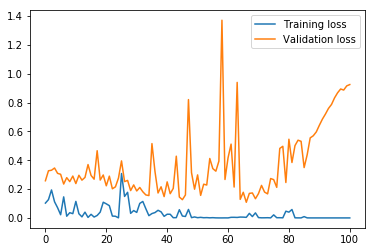

In [135]:

plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend()
_ = plt.ylim()
plt.show()

    

Based on the training and validation loss over epoch, we probably trained the model for too long. Ideally, we would have stopped around 42 epochs. By training for 101 epochs, the validation loss eventually runs away from the training loss, resulting in overfitting.


### Goal 3: Evaluate the neural network and show us the results
#### Testing the Model:

We will test the model using our test_images and test_labels data. We will do this by first creating a method to display a few random predictions. Next, we'll create a method to test the model that will load the model with get_tensor_by_name and run it again our testing data. 

In [147]:
from sklearn.preprocessing import LabelBinarizer
plt.clf()

def display_image_predictions(imagez, labelz, predictions):
    n_classes = 2
    label_names = ["Not Food", "Food"]
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labelz))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 2
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (img, label_id, pred_indicies, pred_values) in enumerate(zip(imagez, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        RGB_img = img[:,:,::-1]    
        axies[image_i][0].imshow(RGB_img)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        axies[image_i][1].barh(ind + margin, pred_values[::-1], [.4,.4])
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])
    
    plt.show()
    print("Display Image Predictions Complete")

INFO:tensorflow:Restoring parameters from ./training_sess
Testing Accuracy: 0.9196428571428571



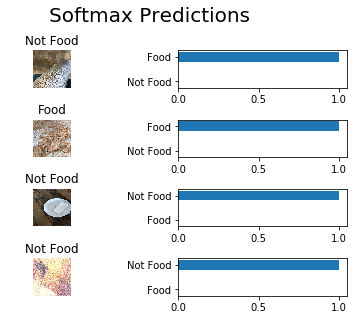

Display Image Predictions Complete


In [148]:
save_model_path = "./training_sess"
n_samples = 4
top_n_predictions = 2

def test_model():
    """
    Test the saved model against the test dataset
    """

    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_image_batch, test_label_batch, test_path_batch in get_mini_batches(batch_size, test_images, test_labels, test_paths):
            
            transposed_images = np.array(test_image_batch).transpose(0, 3, 1, 2)
            
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: transposed_images, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_images, random_test_labels = tuple(zip(*random.sample(list(zip(test_images, test_labels)), n_samples)))
        
        
        transposed_images = np.array(test_image_batch).transpose(0, 3, 1, 2)
            
            
        
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), 2),
            feed_dict={loaded_x: transposed_images, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_images, random_test_labels, random_test_predictions)


test_model()

Woot! This testing accuracy is 8% higher than my previous submission. 

Although I could not get display_image_predictions to function, it was intended to display a few random images and the model's associated probabilites for each class in a table format. However, looking at the testing accuracy, the model's prospects look encouraging. 

### Goal 4: Testing the Network on Local Machines:

Running the following cells will allow you to input the file path of an image, and the model will provide you with a prediction.

In [630]:
# Enter filepath of image
input_img = input()

/Users/sarahhernandez/Documents/4. Important Docs/Passio/tissues.jpg


In [638]:
# Enter 0 if it's Not Food, 1 if it's Food
input_label = input()

0


In [639]:
single_label = []
if input_label == str(0):
    single_label = [1, 0]
elif input_label == str(1):
    single_label = [0, 1]
else:
    print("Invalid label input, please run above cell again")
  

In [640]:
img = cv2.imread(input_img)
img = cv2.resize(img,(256,256))
img = normalize(img)
img_stack = [img]
label_stack = [single_label]

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        

        test_batch_acc_total = 0
        test_batch_count = 0
        
       
        transposed_images = np.array(img_stack).transpose(0, 3, 1, 2)
            
        test_batch_acc_total += sess.run(loaded_acc, feed_dict={loaded_x: transposed_images, loaded_y: label_stack, loaded_keep_prob: 1.0})
        

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total))
        










INFO:tensorflow:Restoring parameters from ./training_sess
Testing Accuracy: 1.0



Wonderful! If the testing accuracy is 1, then the model correctly predicted the given image, if the testing accuracy is 0, then the model failed to predict if the image was food or not food. 


### Future Work:

For further improvements to the program, I would implement the following:

* I would further expand the dataset by randomly cropping, translating and scaling images, or by using an online dataset
* I'd like to see the results of implementing a k-fold cross validation, as it's good to use with limited datasets